In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import InceptionV3
from keras.applications import MobileNetV2
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
RANDOM_STATE = 0

In [ ]:
path_to_cr_data = "/content/drive/MyDrive/Capstone"
img_dirs = []
for entry in os.scandir(path_to_cr_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

img_dirs

['/content/drive/MyDrive/Capstone/Indira_Nooyi',
 '/content/drive/MyDrive/Capstone/Dalai_Lama',
 '/content/drive/MyDrive/Capstone/Melinda_Gates',
 '/content/drive/MyDrive/Capstone/Virat_Kohli',
 '/content/drive/MyDrive/Capstone/Bill_Gates',
 '/content/drive/MyDrive/Capstone/Vikas_Khanna',
 '/content/drive/MyDrive/Capstone/Narendra_Modi',
 '/content/drive/MyDrive/Capstone/Anushka_Sharma',
 '/content/drive/MyDrive/Capstone/Barack_Obama',
 '/content/drive/MyDrive/Capstone/Sundar_Pichai']

In [ ]:
celebrity_file_names_dict={}
for img_dir in img_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list

In [ ]:
for k, v in celebrity_file_names_dict.items():
  print(k, len(v))

Indira_Nooyi 256
Dalai_Lama 231
Melinda_Gates 394
Virat_Kohli 276
Bill_Gates 217
Vikas_Khanna 294
Narendra_Modi 224
Anushka_Sharma 258
Barack_Obama 338
Sundar_Pichai 228


In [ ]:
img_list_height = []
img_list_width = []
for k, v in celebrity_file_names_dict.items():
    for im in v:
        img = cv2.imread(im)
        img_list_height.append(img.shape[0])
        img_list_width.append(img.shape[1])

In [ ]:
IMG_SIZE = [224,224]

In [ ]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Indira_Nooyi': 0,
 'Dalai_Lama': 1,
 'Melinda_Gates': 2,
 'Virat_Kohli': 3,
 'Bill_Gates': 4,
 'Vikas_Khanna': 5,
 'Narendra_Modi': 6,
 'Anushka_Sharma': 7,
 'Barack_Obama': 8,
 'Sundar_Pichai': 9}

In [ ]:
inv_dict = dict(zip(class_dict.values(), class_dict.keys()))
inv_dict

{0: 'Indira_Nooyi',
 1: 'Dalai_Lama',
 2: 'Melinda_Gates',
 3: 'Virat_Kohli',
 4: 'Bill_Gates',
 5: 'Vikas_Khanna',
 6: 'Narendra_Modi',
 7: 'Anushka_Sharma',
 8: 'Barack_Obama',
 9: 'Sundar_Pichai'}

In [ ]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        X.append(img)
        y.append(class_dict[celebrity_name])

In [ ]:
X_train_temp, X_test_temp, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=RANDOM_STATE)

In [ ]:
Total_Pixels = 0
B_sum  = 0
G_sum = 0
R_sum = 0

for img in X_train_temp:
    Total_Pixels = Total_Pixels  + img.shape[0]*img.shape[1]
    (B,G,R) = cv2.split(img)
    B_sum = B_sum + B.sum()
    G_sum = G_sum + G.sum()
    R_sum = R_sum + R.sum()


B_mean = B_sum/Total_Pixels
G_mean = G_sum/Total_Pixels
R_mean = R_sum/Total_Pixels

In [ ]:
X_train = []
for img in X_train_temp:
    if img is not None:
        img_resized = cv2.resize(img, (IMG_SIZE[0], IMG_SIZE[1]))
        (B,G,R) = cv2.split(img_resized)
        B = B - B_mean
        G = G - G_mean
        R = R - R_mean
        img_preprocessed = cv2.merge([B, G, R])
        X_train.append(img_preprocessed)

In [ ]:
X_test = []
for img in X_test_temp:
    if img is not None:
        img_resized = cv2.resize(img, (IMG_SIZE[0], IMG_SIZE[1]))
        (B,G,R) = cv2.split(img_resized)
        B = B - B_mean
        G = G - G_mean
        R = R - R_mean
        img_preprocessed = cv2.merge([B, G, R])
        X_test.append(img_preprocessed)

In [ ]:
del X_train_temp, X_test_temp, B, G, R, B_mean, G_mean, R_mean, img_resized, img_preprocessed, Total_Pixels

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

**VGG19 Model Training**

In [ ]:
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
N_CLASSES = 10
OPTIMIZER = Adam(learning_rate=0.0001)
LOSS_FUNC = 'sparse_categorical_crossentropy'
METRICS = ['accuracy']
EPOCHS = 10
BATCH_SIZE = 32
OUTPUT_ACTIVATION = 'softmax'

In [ ]:
def create_model_vgg19(input_shape, n_classes, optimizer, loss_func, metrics, output_activation, freeze):

    conv_base = VGG19(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    if freeze > 0:
        for layer in conv_base.layers[:-freeze]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False


    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation=output_activation)(top_model)


    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(optimizer=optimizer,
                  loss=loss_func,
                  metrics=metrics)

    return model

In [ ]:
def training_accuracy_plot(history,model):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()

In [ ]:
def training_loss_plot(history,model):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [ ]:
vgg19_model = create_model_vgg19(INPUT_SHAPE, N_CLASSES, OPTIMIZER, LOSS_FUNC, METRICS, OUTPUT_ACTIVATION,0)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
vgg19_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
history_vgg19 = vgg19_model.fit(X_train, y_train, batch_size=BATCH_SIZE, validation_split=0.15,epochs=EPOCHS, shuffle=True)

Epoch 1/10
58/58 [==============================] - 28s 273ms/step - loss: 3.2022 - accuracy: 0.7378 - val_loss: 0.7649 - val_accuracy: 0.9202
Epoch 2/10
58/58 [==============================] - 13s 219ms/step - loss: 0.2001 - accuracy: 0.9588 - val_loss: 0.8053 - val_accuracy: 0.9172
Epoch 3/10
58/58 [==============================] - 13s 221ms/step - loss: 0.0613 - accuracy: 0.9854 - val_loss: 0.6426 - val_accuracy: 0.9448
Epoch 4/10
58/58 [==============================] - 13s 224ms/step - loss: 0.0742 - accuracy: 0.9848 - val_loss: 0.5574 - val_accuracy: 0.9202
Epoch 5/10
58/58 [==============================] - 12s 212ms/step - loss: 0.0842 - accuracy: 0.9865 - val_loss: 0.7407 - val_accuracy: 0.9264
Epoch 6/10
58/58 [==============================] - 12s 215ms/step - loss: 0.0368 - accuracy: 0.9908 - val_loss: 0.8220 - val_accuracy: 0.9110
Epoch 7/10
58/58 [==============================] - 13s 229ms/step - loss: 0.0234 - accuracy: 0.9951 - val_loss: 1.2007 - val_accuracy: 0.8988

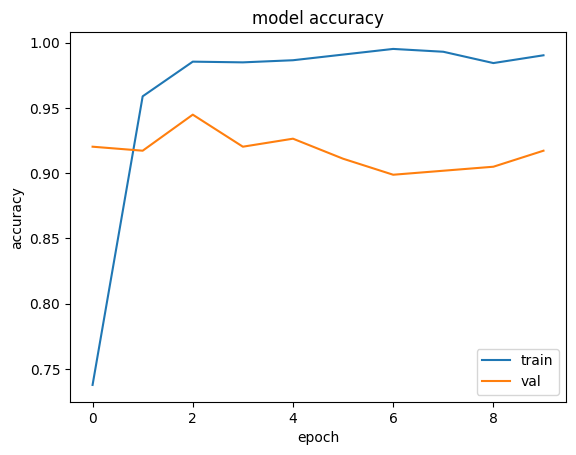

In [ ]:
training_accuracy_plot(history_vgg19,vgg19_model)

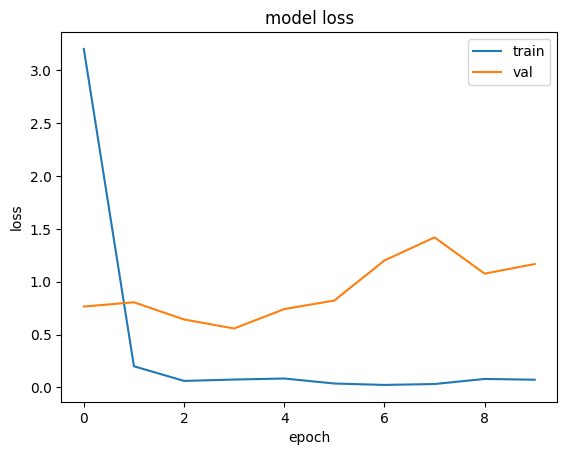

In [ ]:
training_loss_plot(history_vgg19,vgg19_model)

In [ ]:
test_loss, test_accuracy = vgg19_model.evaluate(X_test, y_test)
test_accuracy_vgg19 = test_accuracy*100

17/17 [==============================] - 3s 177ms/step - loss: 0.8769 - accuracy: 0.9301


In [ ]:
y_pred = vgg19_model.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

17/17 [==============================] - 3s 172ms/step


In [ ]:
print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        49
           1       0.98      0.98      0.98        44
           2       0.82      0.96      0.88        74
           3       0.94      0.98      0.96        63
           4       1.00      0.81      0.90        43
           5       0.82      0.95      0.88        57
           6       0.98      0.96      0.97        45
           7       0.92      0.80      0.85        44
           8       0.99      0.97      0.98        71
           9       1.00      0.91      0.95        54

    accuracy                           0.93       544
   macro avg       0.94      0.92      0.93       544
weighted avg       0.94      0.93      0.93       544



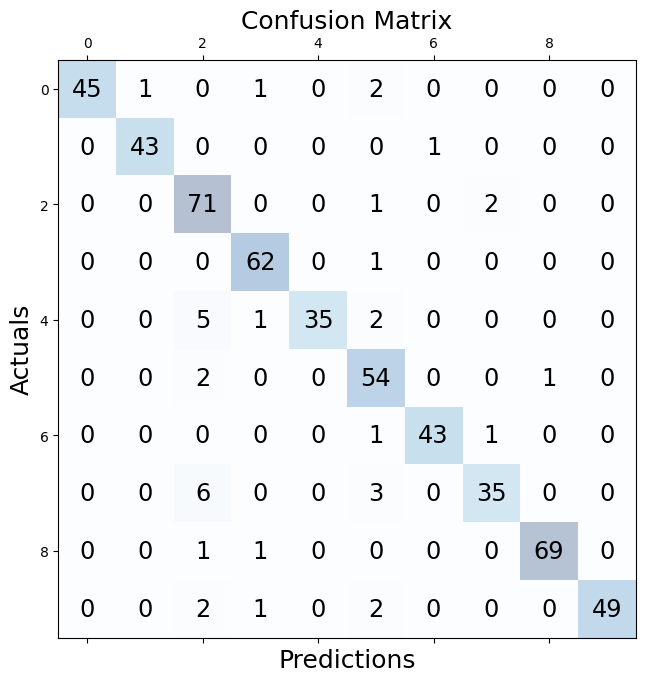

In [ ]:
conf_matrix=confusion_matrix(y_test, y_pred_classes)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [1]:
test_accuracy_resnet = 69.67
test_accuracy_vgg16 = 90.62
test_accuracy_vgg19 = 93.0
test_accuracy_densenet = 82.35
test_accuracy_mobilenet = 88.42

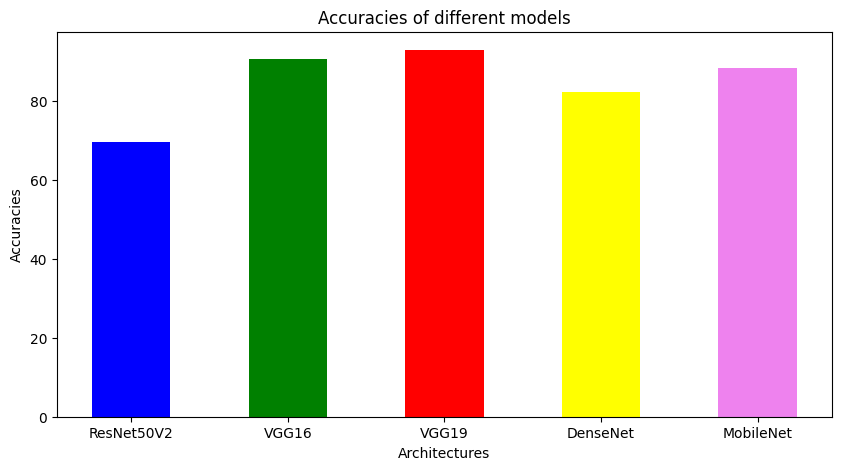

In [4]:
data_dict = {'ResNet50V2': test_accuracy_resnet, 'VGG16':test_accuracy_vgg16, 'VGG19':test_accuracy_vgg19, 'DenseNet':test_accuracy_densenet, 'MobileNet':test_accuracy_mobilenet}
x = list(data_dict.keys())
y = list(data_dict.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(x, y, color =['blue','green','red','yellow','violet'],width = 0.5)
plt.xlabel("Architectures")
plt.ylabel("Accuracies")
plt.title("Accuracies of different models")
plt.show()